# Pandas 3 – Mit DataFrames rechnen

Mit DataFrames kann man nicht nur Metadaten diverser Datentypen bearbeiten, filtern und sortieren, sie eignen sich inbesondere auch sehr gut, um Berechnungen auf größeren Datenmengen einfach und effizient durchzuführen. Darum geht es in diesem Input. 

Als bekannt vorausgesetzt wird hier: DataFrames aus CSV einlesen, DataFrames aus Listen erstellen, DataFrames sortieren, slicen und filtern, DataFrames abspeichern (siehe Pandas 2). 

Neu hier ist: Berechnungen auf mehreren ganzen Spalten; Kombination von numpy mit DataFrames; Visualisierung von DataFrames.  

## Importe

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
import glob
from os.path import join
import os
import pandas as pd
import numpy as np

## Daten: Worthäufigkeiten

Als Beispieldatensatz erstellen wir uns eine Worthäufigkeitstabelle aus einem Textkorpus. 

Das geht am Einfachsten mit der Methode `Count.Vektorizer` aus dem Paket sklearn. Siehe: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [24]:
datafolder = join("..", "data", "doyle", "")

def create_tdm(datafolder):
    # Create idnos and files as lists
    files = glob.glob(join(datafolder, "*.txt"))
    idnos = [os.path.basename(file).split(".")[0] for file in files]
            
    # Define and apply vectorizer
    vectorizer = CountVectorizer(input="filename", min_df=1, max_df=12) # min_df, max_df: document frequency
    tdm = vectorizer.fit_transform(files)
    
    # Get vocabulary and transform to TDM / DataFrame
    vocab = [item[0] for item in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])]
    tdm = pd.DataFrame(tdm.toarray().T, columns=idnos, index=vocab)

    # Sanity check: inspect results
    print("number of texts:", len(files))
    print("number of words:", len(vocab))
    print(tdm.head())
    return tdm

tdm = create_tdm(datafolder)


number of texts: 12
number of words: 25606
      acd006  acd012  acd011  acd001  acd010  acd007  acd005  acd004  acd002  \
000        0       0       0       0       0       0       4       0       0   
10         0       0       0       2       0       1       0       0       0   
1000       1       0       0       0       0       0       0       0       0   
104        0       0       0       0       0       1       0       0       0   
109        0       0       1       0       0       0       0       0       0   

      acd009  acd008  acd003  
000        0       0       0  
10         8       0       0  
1000       0       0       0  
104        0       0       0  
109        0       0       0  


## Metadaten hinzufügen

Jetzt haben wir zwar eine Term-Dokument-Matrix, repräsentiert als DataFrame; und wir haben die Spalten und Zeilen auch schon beschriftet. Aber die Kürzel der Dateien sind doch nicht sehr informativ. Es wäre also schön, (a) sie durch die Kurztitel der Romane (oder andere Informationen) zu ersetzen. 

Wir müssen bedenken, dass die Sortierung der Dokumente in unseren DataFrame und die Sortierung in der Metadatentabelle nicht übereinstimmen müssen. Deswegen sortieren wir beide bevor wir sie verbinden. 

Weil die Funktion parametrisierbar ist, lassen sich leicht andere Metadaten-Kategorien nutzen.

In [25]:
metadatafile = join(datafolder, "metadata.csv")
target = "title" # oder: subgenre, year

def add_metadatum(tdm, metadatafile, target): 
    with open(metadatafile, "r", encoding="utf8") as infile: 
        metadata = pd.read_csv(infile)
        metadata.sort_values(by="idno", ascending=True, inplace=True)
        #print(metadata.head())
    metadatum = list(metadata.loc[:,target])
    #print(metadatum)
    tdm = tdm.reindex(sorted(tdm.columns), axis=1)
    tdm.columns = metadatum
    print(tdm.head())
    return tdm
    
tdm = add_metadatum(tdm, metadatafile, target)

      StudyScarlet  HoundBaskervilles  SignFour  WhiteCompany  Refugees  \
000              0                  0         0             0         4   
10               2                  0         0             0         0   
1000             0                  0         0             0         0   
104              0                  0         0             0         0   
109              0                  0         0             0         0   

      FirmGirdlestone  MysteryCloomber  RafflesHaw  Parasite  LostWorld  \
000                 0                0           0         0          0   
10                  0                1           0         8          0   
1000                1                0           0         0          0   
104                 0                1           0         0          0   
109                 0                0           0         0          0   

      ValleyFear  PoisonBelt  
000            0           0  
10             0           0  
1000 

## Summen bilden: Dokumentlänge, Worthäufigkeit

Zunächst einmal können wir auf einer solchen Term-Dokument-Matrix (repräsentiert als DataFrame) die Dokumentlängen und die Häufigkeiten der Wörter im Korpus ermitteln: durch eine zeilenweise oder spaltenweise Summenbildung. 

Achtung: Wenn wir beim Aufbau der TDM nicht alle Wörter berücksichtigt haben (bspw. wegen Stoplists, minimaler Wortlänge oder minimaler Dokumenthäufigkeit), dann repräsentieren die Zahlen hier natürlich auch nicht die tatsächliche Länge der vollständigen Dokumente. 

In [26]:
import numpy as np

doclens = np.sum(tdm, axis=0) # 0 = spaltenweise = je Text
print(type(doclens),"\n", doclens)

wordcounts = np.sum(tdm, axis=1) # 1 = zeilenweise = je Wort
print(type(wordcounts), "\n\n", wordcounts)

<class 'pandas.core.series.Series'> 
 StudyScarlet          41601
HoundBaskervilles     56633
SignFour              41111
WhiteCompany         146083
Refugees             118824
FirmGirdlestone      132622
MysteryCloomber       46505
RafflesHaw            36335
Parasite              16601
LostWorld             72859
ValleyFear            55494
PoisonBelt            28177
dtype: int64
<class 'pandas.core.series.Series'> 

 000            4
10            11
1000           1
104            1
109            1
              ..
zoological    17
zoologist      4
zoologists     1
zoology        9
zum            2
Length: 25606, dtype: int64


## Relative Häufigkeiten berechnen

Relative Häufigkeiten machen die absoluten Häufigkeiten in Dokumenten unterschiedlicher Länge vergleichbar. Deswegen wird diese Art der "Normalisierung" sehr häufig eingesetzt. 

Wir nehmen die Länge der Dokumente in ihrer Gesamtheit als Grundlage für die Berechnung (siehe oben, `df_min=1`). Wir teilen jede absolute Worthäufigkeit (Zelle) durch die Summe der Worthäufigkeit des relevanten Textes (spaltenweise Summe). 

Statt Zelle pro Zelle durch den DataFrame zu iterieren, dividieren wir gewissermaßen jede Zeile (als ein Vektor) durch die Liste der Dokumentlänge (auch als ein Vektor). Alle Werte einer Zeile (ein Wert pro Dokument für den relevanten Term) werden also durch unterschiedliche Werte geteilt. Man könnte auch sagen: Wir dividieren die ganze TDM durch einen passenden Vektor in Zeilenlänge. 

Wir können die Variable `doclens` von oben nachnutzen. Wir fügen die Summe der relativen Häufigkeiten pro Wort als Spalte hinzu, sortieren danach und inspizieren die häufigsten Wörter. 


In [27]:
# Relative Häufigkeiten
relfreqs = np.divide(tdm, doclens) * 100 # x100 = Prozent
#print(relfreqs.head())

# Sanity check: Welche Wörter sind am häufigsten, und wie häufig?
relfreqs["relfreqsum"] = np.sum(relfreqs, axis=1)
relfreqs.sort_values(by="relfreqsum", inplace=True, ascending=False)
relfreqs.drop("relfreqsum", inplace=True, axis=1)
print(relfreqs.head(10))

      StudyScarlet  HoundBaskervilles  SignFour  WhiteCompany  Refugees  \
the       6.028701           5.855243  5.655421      6.592143  6.541608   
and       3.257133           2.874649  2.887305      3.762929  3.553154   
of        2.882142           2.802253  2.707305      3.286488  2.821821   
to        2.620129           2.486183  2.658656      2.196696  2.276476   
it        1.430254           1.783412  1.695410      1.161668  1.361678   
in        1.733131           1.608603  1.651626      1.438908  1.549350   
that      1.617750           2.020024  1.534869      1.227384  1.262371   
he        1.930242           1.622729  1.568923      1.156877  1.283411   
was       1.564866           1.417901  1.396220      0.825558  1.207668   
you       1.124973           1.472640  1.320814      1.011069  1.327173   

      FirmGirdlestone  MysteryCloomber  RafflesHaw  Parasite  LostWorld  \
the          6.395621         5.995054    5.438283  4.168424   6.125530   
and          3.077921   

## Z-Scores berechnen

Eine weiter gehende Normalisierung von Worthäufigkeiten sind Z-Scores. 

Hier werden für jede relative Worthäufigkeit weitere Berechnungen vorgenommen: Man subtrahiert den Mittelwert der Häufigkeit des Wortes von der relativen Häufigkeit (= "Zentrierung": der neue Mittelwert wird 0 sein); und man dividiert das Ergebnis durch die Standardabweichung der relativen Häufigkeit des Wortes (= Standardisierung: die neue Standardabweichung wird 1 sein). 

Wir müssen den DF transponieren (rotieren), um die Subtraktion ausführen zu können. Wir transponieren ihn zurück, um die gleiche TDM zu bekommen.

Es gibt viele weitere Möglichkeiten, Worthäufigkeiten zu normaliseren, bspw. TF-IDF. 

In [28]:
# Mean relative frequency and standard deviations per word
meanfreqs = np.mean(relfreqs, axis=1)
stdevs = np.std(relfreqs, axis=1)

# Sanity checks: len should be vocabulary, not documents
print(len(meanfreqs))
print(len(stdevs))

# Z-Score transformation: DataFrame by Series
zscores = np.divide(np.subtract(relfreqs.T, meanfreqs), stdevs).T
print(zscores.head())

# Sanity checks: 
# - means should be (close to) 0, zeilenweise; Rundungsfehler
# - stdevs should be (close) 1, zeilenweise
# - min/max should be around -4,+4 not much more
zs_means = np.mean(zscores, axis=1)
zs_stdevs = np.std(zscores, axis=1)
zs_max = np.max(np.max(zscores, axis=1)) # Erst zeilenweise, dann max davon
zs_min = np.min(np.min(zscores, axis=1))
print("means", list(zs_means)[0:10])
print("stdevs", list(zs_stdevs)[0:10])
print("max", zs_max)
print("min", zs_min)


25606
25606
     StudyScarlet  HoundBaskervilles  SignFour  WhiteCompany  Refugees  \
the      0.192658          -0.087154 -0.409496      1.101568  1.020048   
and      0.593684          -0.608246 -0.568475      2.183112  1.523909   
of      -0.061217          -0.377972 -0.754436      1.541985 -0.300389   
to       0.581680          -0.123841  0.784607     -1.648622 -1.228407   
it      -0.832095           0.450953  0.131234     -1.807884 -1.081237   

     FirmGirdlestone  MysteryCloomber  RafflesHaw  Parasite  LostWorld  \
the         0.784550         0.138381   -0.759770 -2.808230   0.348857   
and         0.030521         0.406308   -0.041802 -0.442057  -0.636024   
of         -0.528662         0.131976   -0.216457 -1.170959   2.246703   
to          0.498802         0.881921    0.755287  1.820104  -0.697905   
it         -0.656311        -0.872247    0.900870  1.062315   0.095039   

     ValleyFear  PoisonBelt  
the   -0.076424    0.555011  
and   -1.464765   -0.976164  
of    -1

## Visualisierung von Werten

Für einfache Visualisierungen von Ergebnissen auf der Basis eines DataFrames kann man direkt pandas nutzen. 

Grundlage dafür ist die Methode `.plot()`. 

Siehe: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

Für weitergehende Visualisierungsmöglichkeiten sind Bibliotheken nützlich, die einen DataFrame als Input nutzen können, darunter: Seaborn, Pygal, Matplotlib. 

<class 'pandas.core.series.Series'>


<AxesSubplot:title={'center':'Länge der Dokumente im Korpus'}>

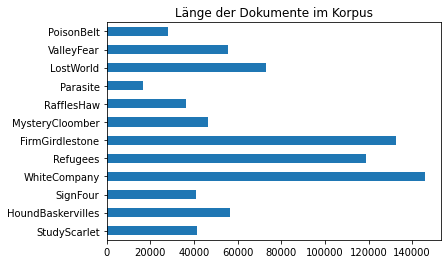

In [29]:
# Dokumentlängen (plot mit Series)

title = "Länge der Dokumente im Korpus"
doclens = np.sum(tdm, axis=0)
print(type(doclens))
doclens.plot(kind="barh", title=title)



Text(0, 0.5, 'Relative Häufigkeit in Prozent')

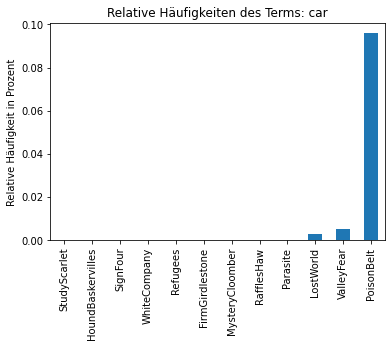

In [30]:
# Verteilung der relativen Häufigkeiten einzelner Wörter in den Texten

term = "car"   # "moor", "crime", "car", "question"
title = "Relative Häufigkeiten des Terms: " + term
ylabel = "Relative Häufigkeit in Prozent"
fig1 = relfreqs.loc[term,:].plot(kind="bar", title=title)
fig1.set_ylabel(ylabel)

Text(0, 0.5, 'Z-Score als Standardabweichung')

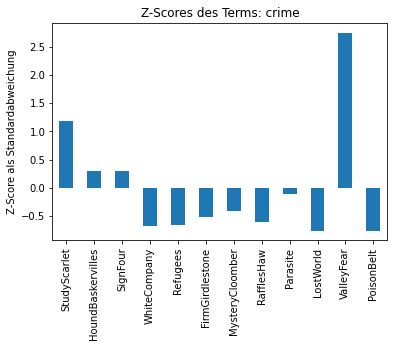

In [31]:
# Verteilung der Z-Scores eines Wortes in den Texten

term = "crime"   # "moor", "crime", "car", "question", "he", "she"
title = "Z-Scores des Terms: " + term
ylabel = "Z-Score als Standardabweichung"

fig1 = zscores.loc[term,:].plot(kind="bar", title=title)
fig1.set_ylabel(ylabel)